## Numerai Tournament 61 Entry

In this notebook I do some profiling on Numer.ai's tournament 61 dataset.  For those not acquainted with numer.ai, it is a crowd sourced hedge fund where data scientists compete to create the best predictive models.  Numerai then uses these predictions to create a meta-model that, as the theory goes, is better than all the disparate models used to create it. 

Numerai runs tournaments each week and the format, as far as I know, is the same each week. This is my first step at creating a mostly automatic pipeline for entering into these tournaments.  Given that numerai allows for 25 predictions a day, there is also a lot of room to experiement with 'magic numbers' and other sorts sorts of hacks to game the competition. That will obviously come later, so the purpose of this notebook is just to get an understanding of the data, the prediction format, and to test out a few models.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# Lets see whats in our input folder
from subprocess import check_output
print(check_output(["ls", "../numerai/T61/"]).decode("utf8"))

example_model.py
example_model.r
example_predictions.csv
numerai_tournament_data.csv
numerai_training_data.csv



In [160]:
# Load Training Data
training_data = pd.read_csv('../numerai/T61/numerai_training_data.csv', header=0)
prediction_data = pd.read_csv('../numerai/T61/numerai_tournament_data.csv', header=0)

# Transform the loaded CSV data into numpy arrays
features = [f for f in list(training_data) if "feature" in f]
X = training_data[features]
Y = training_data["target"]
x_prediction = prediction_data[features]
ids = prediction_data["id"]

In [37]:
print X.shape, Y.shape

(108405, 21) (108405,) (45625, 25)


First we'll get a sense of what type each column is.  I'm presuming that we'll be working primarily with numerical data.

In [19]:
print(X.dtypes)

feature1     float64
feature2     float64
feature3     float64
feature4     float64
feature5     float64
feature6     float64
feature7     float64
feature8     float64
feature9     float64
feature10    float64
feature11    float64
feature12    float64
feature13    float64
feature14    float64
feature15    float64
feature16    float64
feature17    float64
feature18    float64
feature19    float64
feature20    float64
feature21    float64
dtype: object


Python has a handy function that will summarize each column.

In [24]:
print X.describe()

            feature1      feature2       feature3       feature4  \
count  108405.000000  108405.00000  108405.000000  108405.000000   
mean        0.500489       0.52870       0.593131       0.463543   
std         0.090130       0.10490       0.098372       0.096387   
min         0.000000       0.00000       0.000000       0.000000   
25%         0.455870       0.46791       0.540400       0.408910   
50%         0.499290       0.53508       0.594830       0.466530   
75%         0.546790       0.59569       0.648070       0.520500   
max         1.000000       1.00000       0.994840       1.000000   

            feature5       feature6       feature7       feature8  \
count  108405.000000  108405.000000  108405.000000  108405.000000   
mean        0.430014       0.500072       0.533695       0.484669   
std         0.087958       0.102223       0.098016       0.087952   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.376880       0.436020       

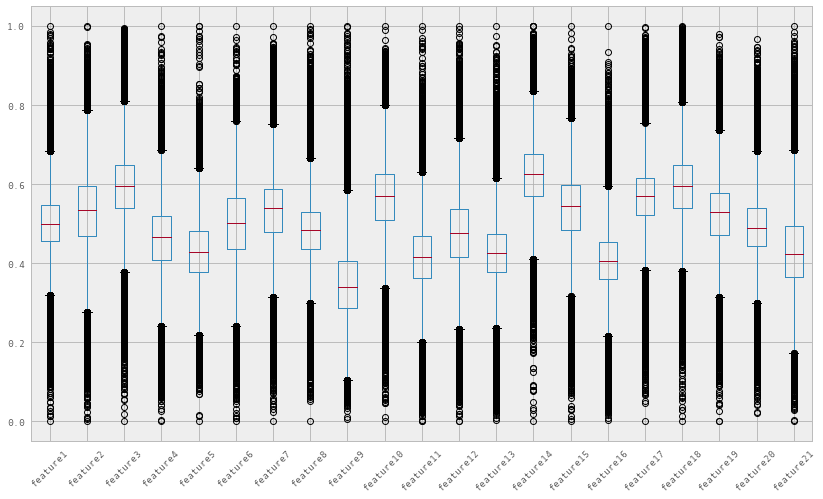

In [33]:
pd.options.display.mpl_style = 'default'

X.boxplot(figsize=(14,8), rot = 45);

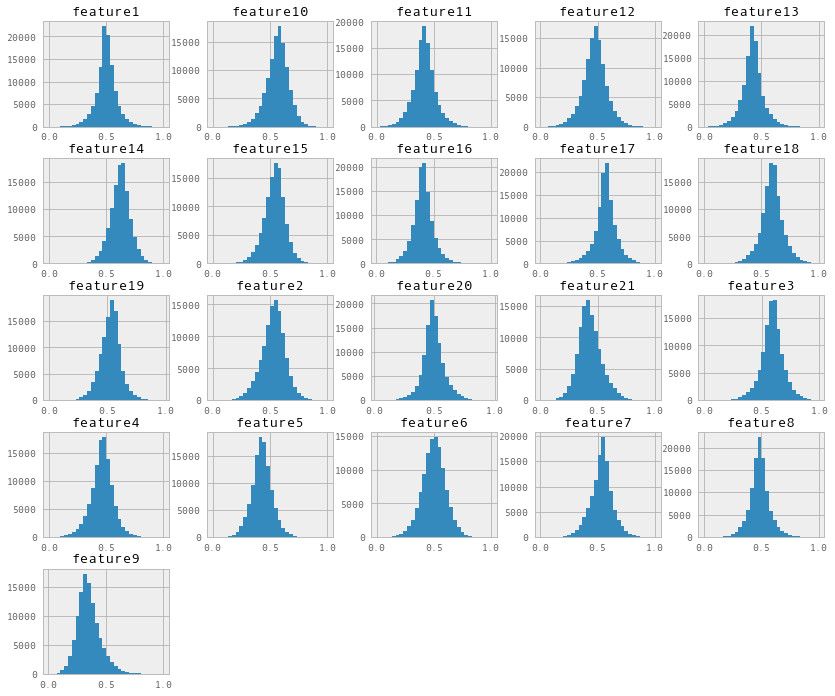

In [36]:
X.hist(figsize=(14, 12), bins=30);

Our data looks to be approximately normally distributed between 0 and 1, so theres no immediate need for us to do any sort of additional normalization.

I have heard the misconception that machine learning algorithms do not need normalization.  This is false.  Imagine a loss function mapped across a 2 dimensional feature space, whereby one of features has a range >> than the other.  The gradient descent algorithm for movement along this feature space will not be able to differentiate between the two ranges, and will conversely,  fail to navigate to the loss minimizing value along the lower feature range.

I will first be splitting the data into a training and validation set so I can get a better picture of out of sample performance.

In [40]:
# split into test and train
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=False)

First I will be seeing what my performance is looking like out of sample so I can get a sense of how much tuning will be necessary.

I will be running a simple XGBoosted model with some paramaters tuned from a prior Kaggle competition.

In [41]:
import xgboost as xgb # xgboost package 

# Split training and validation datasets
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

I tend to build models with early stopping, so that if the validation performance doesn't improve in over *n* rounds, the final model will use whatever was the last configuration before the *n* iterations.

In [135]:
params = {}
params['eta'] = 0.02 # control the learning rate: scale the contribution of each tree by a factor of 0 < eta < 1. Lower is slower but more robust to overfitting.
params['objective'] = 'binary:logistic' # Default.  Running a regression, since we're predicting values not classes
params['eval_metric'] = 'logloss' # We're evaluating our models on Mean Average Error.  
params['max_depth'] = 6 # Maximum depth of a tree, increase this value will make the model more complex / likely to be overfitting.
params['silent'] = 1 # Don't print messages

# We will be tuning our model based on how it does in the validation dataset 
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# Early stopping
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.693028	valid-logloss:0.69312
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.691948	valid-logloss:0.692913
[20]	train-logloss:0.690984	valid-logloss:0.692734
[30]	train-logloss:0.690102	valid-logloss:0.692609
[40]	train-logloss:0.689299	valid-logloss:0.692501
[50]	train-logloss:0.688555	valid-logloss:0.692459
[60]	train-logloss:0.687853	valid-logloss:0.692441
[70]	train-logloss:0.687231	valid-logloss:0.692426
[80]	train-logloss:0.686782	valid-logloss:0.69244
[90]	train-logloss:0.686489	valid-logloss:0.69244
[100]	train-logloss:0.686231	valid-logloss:0.692458
[110]	train-logloss:0.685894	valid-logloss:0.6925
[120]	train-logloss:0.685616	valid-logloss:0.692557
[130]	train-logloss:0.685286	valid-logloss:0.692594
[140]	train-logloss:0.685012	valid-logloss:0.692656
[150]	train-logloss:0.684729	valid-logloss:0.692697
[160]	train-logloss:0.684432	val

In [116]:
d_prediction = xgb.DMatrix(x_prediction)

In [125]:
results = clf.predict(d_prediction)
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)

print("Writing predictions to predictions.csv")
# Save the predictions out to a CSV file
joined.to_csv("predictions.csv", index=False)
print("Done!")

Writing predictions to predictions.csv
Done!


Wow, thats a shocker.  I've never seen a model improve so little after the first iteration.  I think it might be because the data is so cleaned already. I dont think I'll do any tuning at this moment, and I'll wait to see how my other models perform on this dataset.

In [127]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score

I'll be running 5 fold cross validation on our training set to generate predictions on our validation dataset.

In [62]:
# import cross validation packages
from sklearn.model_selection import KFold

## Building KFolds with 5 Folds
KFold_5 = KFold(5)

I'm testing a few different models with relatively random hyper-paramaters- I'll be likely building an ensemble model at this point so I'm trying to get a sense of what models I'll want to tune later.

In [ ]:
names = ["LR-C=0.01", "LR-C=0.1", "LR-C=1", "LR-C=10",  
         "KNN-50", "KNN-500", "KNN-5000",
         "GBR ls",
         "Random Forest 100", "Random Forest 10"]

regressors = [
    LogisticRegression(C = 0.01),
    LogisticRegression(C = 0.1),
    LogisticRegression(C = 1),
    LogisticRegression(C = 10),
    KNeighborsClassifier(50),
    KNeighborsClassifier(500),
    KNeighborsClassifier(5000),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.02, random_state=0),
    RandomForestClassifier(n_estimators=100),
    RandomForestClassifier(n_estimators=10),   
]

for name, reg in zip(names, regressors):
    reg.fit(x_train, y_train)
    predicted = reg.predict_proba(x_valid)
    #predicted = cross_val_predict(reg, x_valid, y_valid, cv=KFold_5)
    print name, metrics.log_loss(y_valid, predicted)

With the exeption of the penalized logistic regression model, none of the other tested models outperform the XGBoosted model on the validation dataset.  The good news is that we're seeing promising results from the linear regression models and KNN models.  If you're ensembling, you first and foremost want high performing models.  But you also want to ensure that your models are different in ways to compensate one another.  For example, you'd stand little to gain pairing a number of forest based models since they'll likely be strong and weak in many of the same ways.

I'm learning towards my ensemble combining a K-Nearest Neighbors model, a penalized logistic regression, and an XGboost model. I'll see what sort of performance I get on the Numerai leaderboard before I try tuning the parameters. To ensemble, I'll simply average the prediction probabilities over the full dataset.

In [151]:
d_X = xgb.DMatrix(X, label=Y)

params = {}
params['eta'] = 0.02 # control the learning rate: scale the contribution of each tree by a factor of 0 < eta < 1. Lower is slower but more robust to overfitting.
params['objective'] = 'multi:softprob' 
params['eval_metric'] = 'logloss' # We're evaluating our models on Mean Average Error.  
params['max_depth'] = 6 # Maximum depth of a tree, increase this value will make the model more complex / likely to be overfitting.
params['silent'] = 1 # Don't print messages
params['num_class'] = 2

In [152]:
LR_CLF = LogisticRegression(C = 10)
KN_CLF = KNeighborsClassifier(5000)

Fit our models...

In [153]:
XG_CLF = xgb.train(params, d_X, num_boost_round=64)
LR_CLF.fit(X, Y)
KN_CLF.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5000, p=2,
           weights='uniform')

Generate out predictions...

In [161]:
d_prediction = xgb.DMatrix(x_prediction)

In [170]:
XG_prediction = XG_CLF.predict(d_prediction)
LR_prediction = LR_CLF.predict_proba(x_prediction)
KN_prediction = KN_CLF.predict_proba(x_prediction)

Average and print our predictions to CSV...

In [175]:
y_prediction = (XG_prediction + XG_prediction + KN_prediction)/3
results = y_prediction[:, 1]
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)

print("Writing predictions to predictions.csv")
# Save the predictions out to a CSV file
joined.to_csv("predictions_0624.csv", index=False)
print("Done!")

Writing predictions to predictions.csv
Done!


With our 3 model ensemble we have a score of 0.6927 on Numer.ai.  Enough for a paltry 300th place, but the model is both original, concordant, and 75% consistent on historical datasets.  With tuning and some feature engineering we'll hopefully be able to bring this down to below 0.69, enough for a top 200 finish.